# Проект по увеличению выручки для интернет-магазина

## Введение

В предстоящем проекте наша глобальная задача - найти оптимальный способ увеличения выручки интернет-магазина. У нас есть список гипотез, которые предоставил отдел маркетинга. Мы приоритизируем гипотезы согласно фреймворкам RICE и ICE, а затем проведем A/B тест самой приоритетной гипотезы.
В процессе проведения А/В тестирования мы проведем стандартные шаги анализа получаемых данных: 
1. Оценим кумулятивные данные (чек, выручка, конверсия) и построим необходимые графики; 
2. Определим абнормальные данные (слишком большой чек или слишком большое количество заказов);
3. Рассчитаем стастистическую значимость различий по всем данным и по данным без аномалий;
4. Сделаем выводы на основе полученных данных;
5. Примем решение о продолжении или прекращении A/B теста.

## Знакомство с данными

In [218]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

Мы импортировали нужные для работы библиотеки

### Импорт датасетов

In [219]:
try: 
    hypothesis = pd.read_csv('C:/Praktikum/a_b_test_project/hypothesis_ab.csv')
    orders = pd.read_csv('C:/Praktikum/a_b_test_project/orders_ab.csv')
    visitors = pd.read_csv('C:/Praktikum/a_b_test_project/visitors_ab.csv')
except: 
    hypothesis = pd.read_csv('/datasets/hypothesis.csv') # указали локальный и общий пути
    orders = pd.read_csv('/datasets/orders.csv')
    visitors = pd.read_csv('/datasets/visitors.csv')

In [220]:
hypothesis.info()
orders.info()
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   

Мы импортировали файлы и посмотрели основную информацию: названия колонок, типы файлов, количество строк.

### Предобработка данных

In [221]:
hypothesis.columns = hypothesis.columns.str.lower() # переводим названия в нижний регистр
orders.columns = orders.columns.str.lower()
orders.rename({'transactionid':'transaction_id', 'visitorid':'visitor_id'}, axis=1, inplace = True) # переименовываем
orders['date'] = pd.to_datetime(orders['date']) # приводим к формату даты
visitors.columns = visitors.columns.str.lower()
visitors['date'] = pd.to_datetime(visitors['date'])

Основываясь на наблюдениях из предыдущего пункта, мы привели к удобному формату данные и названия колонок: поменяли тип данных в колонках с датами, перевели названия колонок в нижний регистр, изменила названия, где это было необходимо.

In [222]:
hypothesis.info() 
orders.info()
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB
<class 'pandas.core.frame

Проверили, все ли изменения сработали.

In [223]:
display(visitors.duplicated().sum(), orders.duplicated().sum(), hypothesis.duplicated().sum())

0

0

0

Проверили данные на наличие дубликатов, их не оказалось. На этом предобработку данных можно считать законченной.

In [224]:
orders.groupby('visitor_id', as_index=False)\
    .agg({'group':'nunique'})\
    .query("group==2").count()

visitor_id    58
group         58
dtype: int64

Мы посмотрели, есть ли пользователи, которые вошли в обе группы. 
Видим, что 58 пользователей попали в обе группы теста, что говорит о некорректности работы механизма разделения пользователей. Есть две стратегии, как мы можем поступить:
- удалить
- оставить

Так как удалять их нужно из всех данных теста, а такого мы сделать не можем (таблица визитов агрегирована по дням), то придется их оставить.

## Приоритизация гипотез

### Знакомство с данными

In [225]:
pd.set_option("display.max_colwidth", 150)
display(hypothesis)

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Мы рассмотрели девять гипотез, которые предоставил нам отдел маркетинга. Все они выглядят довольно многообещающими, но, чтобы сэкономить деньги и время, нам нужно выбрать самую надежную гипотезу. Это мы сделаем с помощью двух методов: ICE и RICE.
Эти методы используют в расчетах количество ресурсов, необходимое на реализацию этой гипотезы, количество пользователей, которых затронет это изменение, насколько сильно оно повлияет на пользователей, и то, насколько мы уверены в этих прогнозах.
Отдел маркетинга уже предоставил нам эти данные, так что наша задача - приоритизировать гипотезы по формуле.

### Расчёт приоритизации по методу ICE

In [226]:
hypothesis['ICE'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'].round()
hypothesis[['hypothesis','ICE']].sort_values(by='ICE', ascending=False)
hypothesis

,hypothesis,reach,impact,confidence,efforts,ICE
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000


Мы приоритизировали гипотезы по методу ICE. Этот метод включает три параметра: 
1. Impact - насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта, 
2. Efforts - сколько стоит протестировать эту гипотезу,
3. Confidence - насколько мы уверены, что это изменение повлияет на пользователей именно так.

Согласно этому методу, три самые приоритетные гипотезы  - это:
1. Запуск акции, дающую скидку на товар в день рождения,
2. Добавление двух новых каналов привлечения трафика, что позволит привлекать на 30% больше пользователей,
3. Добавление формы подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.

Но чтобы принять решение о проведение A/B теста по одной из этих гипотез, нам нужно проверить нашу приоритизацию еще по одному методу - RICE. В этом методе используется дополнительный параметр - Reach - скольких пользователей затронет изменение, которое мы хотим внести.

### Расчет приоритизации по методу RICE

In [227]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'].round()
hypothesis[['hypothesis','RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Согласно расчету приоритизации по методу RICE, в топе-3 оказались следующие гипотезы:
1. Добавление формы подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок,
2. Добавление блоков рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа,
3. Добавление двух новых каналов привлечения трафика, что позволит привлекать на 30% больше пользователей,

Действительно, если мы добавляем фактор reach, то гипотеза про скидку на товар в день рождения проигрывает, ведь она охватывает лишь тех пользователей, у которых день рождения в этот конкретный день.


### Вывод по приоритизации гипотез

In [228]:
display(hypothesis.sort_values(by='RICE', ascending=False))
pd.reset_option("display.max_colwidth", 150)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0


Если проанализировать получившуюся приоритизацию гипотез по методам RICE и ICE вместе, то можно увидеть, что в первых трех гипотезах по каждому из методов два совпадают. 

Это добавление формы подписки на всех основных страницах и добавление двух новых каналов привлечения трафика.
В таблице с значениями обоих параметров можно посмотреть баллы, набранные гипотезами по обоим методам.
Исходя из них, самой перспективной гипотезой мы считаем добавление формы подписки. 
У этой гипотезы немного меньше (на 2,1) балла по метрике ICE, но значительно больше (на 72) балла по методике RICE.

В следующем разделе мы будем наблюдать за проведением A/B теста по этой теории.

## Анализ А/B-теста

В предстоящем разделе мы проанализируем результаты A/B теста по выбранной в предыдущем разделе гипотезе. Это добавление формы подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок. Ход наших действий следующий:
1. Оценим кумулятивные данные (чек, выручка, конверсия) и построим необходимые графики; 
2. Определим анормальные данные (слишком большой чек или слишком большое количество заказов);
3. Рассчитаем стастистическую значимость различий по всем данным и по данным без аномалий;
4. Сделаем выводы на основе полученных данных;
5. Примем решение о продолжении или прекращении A/B теста.

Но сначала нам необходимо ознакомиться с исходными данными.

### Знакомство с данными

В первом разделе проекта мы уже ознакомились с данными, но сейчас нужно обратить внимание на дополнительные детали: насколько равномерно распределены пользователи по группам и что происходит с выручкой в обеих группах.

In [229]:
orders.head(5) # посмотрели на таблицу

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [230]:
orders.groupby(['group']).agg({'visitor_id':'nunique'})

,visitor_id
group,
A,503
B,586


<a class="anchor" id="21-bullet">

Для каждого пользователя у нас назначена группа - это мы видим в данных (таблица <code>orders</code>). Если тест спроектирован корректно, то на всем протяжении группа пользователя не меняется - попробуем рассчитать сколько уникальных групп есть для каждого пользователя. Берем таблицу заказов, группируем по пользователю и считаем уникальное кол-во групп

In [231]:
print(orders['date'].min()) 
print(orders['date'].max()) # информация о датах теста пригодится дальше

2019-08-01 00:00:00
2019-08-31 00:00:00


In [232]:
orders.groupby(['group']).agg({'revenue':'sum'}) # посчитали сумму продаж

,revenue
group,
A,4084803
B,5907760


Мы оценили общую сумму продаж в каждой группе - в группе B (то есть до внесения изменений) выручка значительно больше. В ходе дальнейшего анализа мы определим, является ли эта разница статистически значимой.

In [233]:
visitors.head(5) # посмотрели на вторую таблицу

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [234]:
print(visitors['date'].min())
print(visitors['date'].max()) # даты в таблицах посетителей и продаж совпадают

2019-08-01 00:00:00
2019-08-31 00:00:00


In [235]:
visitors.groupby(['group']).agg({'visitors':'sum'}) # посчитали количество посещений

,visitors
group,
A,18736
B,18916


В процессе обработки данных мы увидели, что в списке пользователей есть те, кто оказался в обеих группах одновременно: возможно, это пользователи, которые делали несколько заказов в разные дни, поэтому им случайно попались разные виды страниц.
К сожалению, это говорит о некачественном разделении на группы, хоть и общее количество посетителей в каждой группе примерно одинаковое.
Мы не можем удалить этих пользователей совсем, так как они остались в общем списке посетителей и оттуда их не убрать. Поэтому мы будем тщательнее работать с выбросами, смотреть на среднее количество заказов по пользователям и убирать тех, кто сделал аномальное количество заказов. Скорее всего, эти пользователи совпадут с неверно распределенными, потому что заказов они делали больше одного.

### Расчет кумулятивных метрик

In [236]:
dates_groups = orders[['date','group']].drop_duplicates()

Создали массив уникальных пар значений дат и групп теста.

In [237]:
orders_aggregated = (
                     dates_groups
                     .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
                     .agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1)
                     .sort_values(by=['date','group'])
)
# получаем агрегированные кумулятивные по дням данные о заказах

In [238]:
visitors_aggregated = (
                        dates_groups
                        .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
                        .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)
                        .sort_values(by=['date','group'])
)
# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина

In [239]:
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
print(cumulative_data.head(5)) 

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   148579       719
1 2019-08-01     B      21      20   101217       713
2 2019-08-02     A      44      38   242401      1338
3 2019-08-02     B      45      43   266748      1294
4 2019-08-03     A      68      62   354874      1845


Построим графики кумулятивной выручки по дням и группам A/B-тестирования:

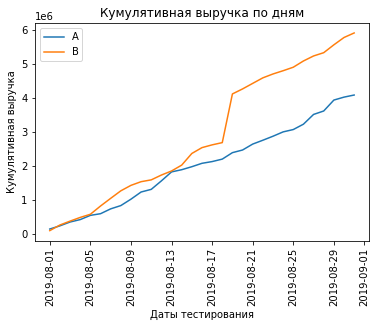

In [240]:
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')

plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')
plt.xticks(rotation=90)
plt.title("Кумулятивная выручка по дням")
plt.xlabel("Даты тестирования")
plt.ylabel("Кумулятивная выручка")
plt.legend() 
plt.show()

Выручка почти равномерно увеличивается в течение всего теста. Хороший знак.
Однако графики выручки группы В в одной точке резко растет. Это может сигнализировать или о резком увеличении числа заказов или об очень дорогих заказах.

<a class="anchor" id="22-bullet">

Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов:

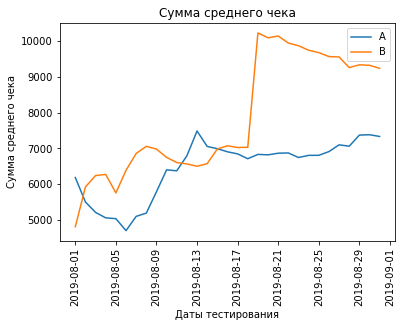

In [241]:
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='B')
plt.legend()
plt.xticks(rotation=90)
plt.title("Сумма среднего чека")
plt.xlabel("Даты тестирования")
plt.ylabel("Сумма среднего чека")
plt.show()

Графики ведут себя непредсказуемо: в обеих группах были резкие подъемы продаж, в группе В в один день средний чек увеличился аж в 1,5 раза. Это явно говорит о выбросе в значениях. Это мы проверим дальше.

Построим график относительного различия для среднего чека. Добавим горизонтальную ось методом axhline() (от англ. horizontal line across the axis*, «горизонтальная линия поперек оси»):

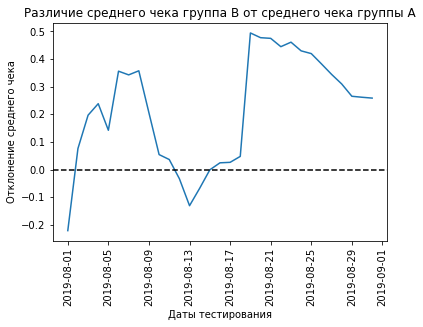

In [242]:
cumulative_revenue_merge = cumulative_revenue_a.merge(cumulative_revenue_b, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
# собираем данные в одном датафрейме
plt.plot(cumulative_revenue_merge['date'], (cumulative_revenue_merge['revenueB']/cumulative_revenue_merge['ordersB'])/(cumulative_revenue_merge['revenueA']/cumulative_revenue_merge['ordersA'])-1)
# cтроим отношение средних чеков
plt.axhline(y=0, color='black', linestyle='--')
# добавляем ось X
plt.xticks(rotation=90)
plt.title("Различие среднего чека группа В от среднего чека группы А")
plt.xlabel("Даты тестирования")
plt.ylabel("Отклонение среднего чека")
plt.show()

В нескольких точках график различия между сегментами резко «скачет». Это тоже нам говорит о выбросах.

Аналогично проанализируем график кумулятивной конверсии.

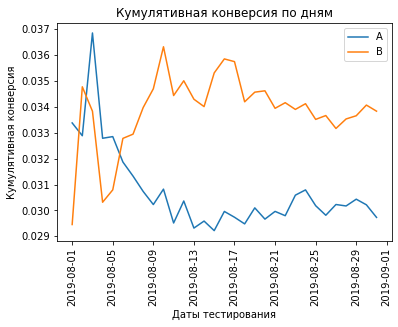

In [243]:
# считаем кумулятивную конверсию
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

# отделяем данные по группе A
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

# отделяем данные по группе B
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

# строим графики
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')
plt.legend()

# задаем масштаб осей

plt.xticks(rotation=90)
plt.title("Кумулятивная конверсия по дням")
plt.xlabel("Даты тестирования")
plt.ylabel("Кумулятивная конверсия")
plt.show()

Получился почти симметричный график. Группы колебались около одного значения, но затем конверсия группы В вырвалась вперёд и зафиксировалась, а конверсия группы А просела и также зафиксировалась.

Построим график относительного различия кумулятивных конверсий:

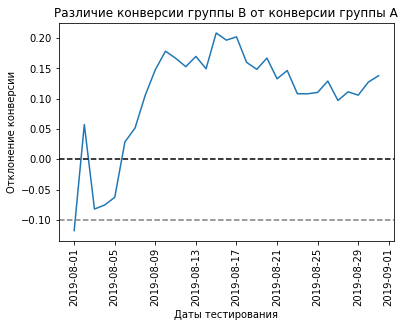

In [244]:
cumulative_conversion_merge = cumulative_data_a[['date','conversion']].merge(cumulative_data_b[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(cumulative_conversion_merge['date'], cumulative_conversion_merge['conversionB']/cumulative_conversion_merge['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')

plt.xticks(rotation=90)
plt.title("Различие конверсии группы В от конверсии группы А")
plt.xlabel("Даты тестирования")
plt.ylabel("Отклонение конверсии")
plt.show()

Конверсия группы В явно закрепилась выше конверсии группы А. 
Пока и графики и общая выручка говорит нам о том, что до изменений продажи шли лучше, чем после.
В следующем разделе отчета мы рассмотрим количество заказов и средний чек в каждой группе и посчитаем, являются ли эти различия статистически значимыми.

### Анализ выбросов и всплесков

Как мы увидели в графиках прошлого раздела, в заказах явно были выбросы - чеки или количество заказов, которые значительно отличались от среднего. В этом разделе мы найдем их и определим, насколько сильно они влияют на результат.

#### Аномальное количество заказов

В этом разделе проекта мы посчитаем, какое количество заказов для одного пользователя является аномальным.

In [245]:
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users.columns = ['user_id', 'orders']

print(orders_by_users.sort_values(by='orders', ascending=False).head(10))

         user_id  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5
744   3062433592       5
55     237748145       5
917   3803269165       5
299   1230306981       5
897   3717692402       5


Мы посчитали количество заказов на каждого пользователя.

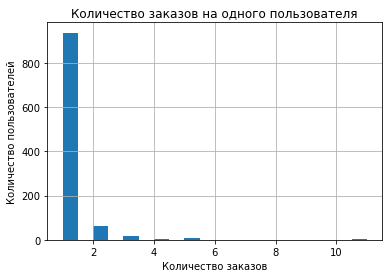

In [246]:
orders_by_users['orders'].hist(bins=20)
plt.title("Количество заказов на одного пользователя")
plt.xlabel("Количество заказов")
plt.ylabel("Количество пользователей")
plt.show()

И построили гистограмму, показывающее распределение количества заказов на одного пользователя. Видно, что основное количество пользователей делает один или два заказа, редко три. Но на гистограмме есть и пользователи, которые сделали пять или даже десять заказов. Чтобы понять, сколько их среди всех пользователей, мы построим диаграмму рассеяния.

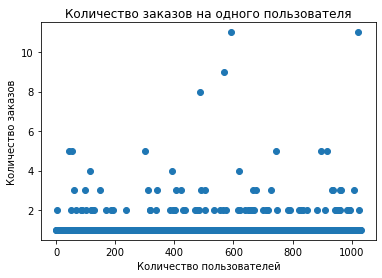

In [247]:
x_values = pd.Series(range(0, len(orders_by_users)))
plt.scatter(x_values,orders_by_users['orders'])
plt.title("Количество заказов на одного пользователя")
plt.xlabel("Количество пользователей")
plt.ylabel("Количество заказов")
plt.show()

Диаграмма рассеяния подтвердила выводы, сделанные по гистограмме: больше двух заказов делают одиночные пользователи, большинство все-таки ограничиваются одним. Дальше мы посмотрим, как распределено количество заказов в процентном соотношении.

In [248]:
print(np.percentile(orders_by_users['orders'],[90,95,99]))

[1. 2. 4.]


Мы посчитали распределение количества заказов в процентном соотношении среди всех пользователей. Как и ожидалось, 90% пользователей делает один заказ, 5% два, и всего лишь 1% пользователей делает больше 4 заказов. При этом этот один процент пользователей значительно влияет на статистику. Мы примем его за выброс в данных и в следующем разделе проекта подсчитаем статистические коэффициенты без этих заказов.

#### Аномальная сумма заказа

В этом разделе мы подсчитаем, какая сумма чека является аномальной.

In [249]:
print(orders.sort_values(by='revenue', ascending=False).head(10))

      transaction_id  visitor_id       date  revenue group
425        590470918  1920142716 2019-08-19  1294500     B
1196      3936777065  2108080724 2019-08-15   202740     B
858        192721366  1316129916 2019-08-27    93940     A
1136       666610489  1307669133 2019-08-13    92550     A
744       3668308183   888512513 2019-08-27    86620     B
682       1216533772  4266935830 2019-08-29    78990     B
662       1811671147  4266935830 2019-08-29    78990     A
743       3603576309  4133034833 2019-08-09    67990     A
1103      1348774318  1164614297 2019-08-12    66350     A
1099       316924019   148427295 2019-08-12    65710     A


Мы отсортировали покупки по убыванию. Видно, что первые несколько чеков явно больше, чем чеки дальше.

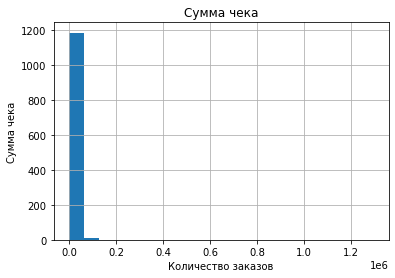

In [250]:
orders['revenue'].hist(bins=20)
plt.title("Сумма чека")
plt.xlabel("Количество заказов")
plt.ylabel("Сумма чека")
plt.show()

Мы построили гистограмму, показывающую среднюю сумму чека. Средний чек держится в пределах 50 000 рублей, но есть чеки превыщающие эту сумму. Чтобы рассмотреть их подробнее мы построим диаграмму рассеяния.

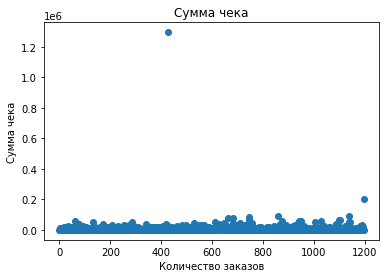

In [251]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title("Сумма чека")
plt.xlabel("Количество заказов")
plt.ylabel("Сумма чека")
plt.show()

Диаграмма рассеяния подтверждает, что основная сумма чеков ниже 50 000 рублей, но есть один, превышающий миллион. Он явно лишний в этой статистике.

In [252]:
print(np.percentile(orders['revenue'],[90,95,99]))

[18168.  28000.  58233.2]


Мы посчитали распределение суммы заказов в процентном соотношении среди всех чеков. 90% чеков даже не на 50 000, а ниже 18 000 рублей, стоимость 95% заказов ниже 28 000 рублей. И только один процент чеков превышает 58 000 рублей. При этом этот один процент пользователей значительно влияет на статистику. Мы примем его за выброс в данных и в следующем разделе проекта подсчитаем статистические коэффициенты без этих заказов.

### Анализ статистической значимости на сырых данных

В этом разделе мы посчитаем, является ли статистически значимой разница двух анализируемых групп. Наша <b>нулевая гипотеза</b>, состоит в том, что <b>статистически значимой разницы между двумя группами нет</b>. Соответственно <b>альтернативная гипотеза</b>, что <b>разница между группами есть</b>. А относительное различие между группами покажет нам, есть ли оно и у какой группы конверсия выше.

<a class="anchor" id="24-bullet">

In [253]:
visitors_a_daily = visitors.query('group == "A"')[['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a'] # количество посетителей в день в группе А

visitors_a_cummulative = visitors_a_daily.apply(
    lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}
    ),
    axis=1,
)
visitors_a_cummulative.columns = ['date', 'visitors_cummulative_a'] # кумулятивное количество посетителей в группе А

visitors_b_daily = visitors.query('group == "B"')[['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b'] # количество посетителей в день в группе В

visitors_b_cummulative = visitors_b_daily.apply(
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}
    ),
    axis=1,
)
visitors_b_cummulative.columns = ['date', 'visitors_cummulative_b'] # кумулятивное количество посетителей в группе В


orders_a_daily = (
    orders.query('group == "A"')[['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a'] # дневная выручка в группе А

orders_a_cummulative = orders_a_daily.apply(
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_a_cummulative.columns = [
    'date',
    'orders_cummulative_a',
    'revenue_cummulative_a',
] # кумулятивная выручка в группе А

orders_b_daily = (
    orders.query('group == "B"')[['date','transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b'] # дневная выручка в группе В

orders_b_cummulative = orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_b_cummulative.columns = [
    'date',
    'orders_cummulative_b',
    'revenue_cummulative_b',
] # кумулятивная выручка в группе В
data = (
    orders_a_daily.merge(
        orders_b_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cummulative, left_on='date', right_on='date', how='left')
) #собранные данные в одну таблицу

In [254]:
print(data.head())

        date  orders_per_date_a  revenue_per_date_a  orders_per_date_b  \
0 2019-08-01                 24              148579                 21   
1 2019-08-02                 20               93822                 24   
2 2019-08-03                 24              112473                 16   
3 2019-08-04                 16               70825                 17   
4 2019-08-05                 25              124218                 23   

   revenue_per_date_b  orders_cummulative_a  revenue_cummulative_a  \
0              101217                    24                 148579   
1              165531                    44                 242401   
2              114248                    68                 354874   
3              108571                    84                 425699   
4               92428                   109                 549917   

   orders_cummulative_b  revenue_cummulative_b  visitors_per_date_a  \
0                    21                 101217                 

Мы собрали в одной таблицу данные о выручке и количестве посетителей по каждому дню эксперимента в каждой группе.

In [255]:
orders_by_users_a = (
    orders.query('group == "A"')
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id':pd.Series.nunique})
)
orders_by_users_a.columns = ['visitor_id', 'orders']

orders_by_users_b = (
    orders.query('group == "B"')
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id':pd.Series.nunique})
)
orders_by_users_b.columns = ['visitor_id', 'orders']


sample_a = pd.concat(
    [
        orders_by_users_a['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b = pd.concat(
    [
        orders_by_users_b['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
mannwhitney_nonfilt = stats.mannwhitneyu(sample_a, sample_b, True, 'two-sided')[1]
relative_conversion_nonfilt = data['orders_per_date_b'].sum()/data['visitors_per_date_b'].sum()/(data['orders_per_date_a'].sum()/data['visitors_per_date_b'].sum())-1
# создали переменные, в которых пользователям с заказами будет соответствовать число заказов пользователя
print('Cтатистическая значимость различия конверсии по тесту Манна-Уитни',"{0:.3f}".format(mannwhitney_nonfilt))

print('Относительное различие в конверсии между группами',"{0:.3f}".format(relative_conversion_nonfilt))

alpha = 0.05 # устанавливаем уровень значимости

if mannwhitney_nonfilt < alpha:
    print("Отвергаем нулевую гипотезу, есть стастистически значимая разница между группами А и В.")
else:
    print("Принимаем нулевую гипотезу, статистически значимой разницы между группами А и В нет.")


if relative_conversion_nonfilt:
    print('Конверсия в группе В выше, чем конверсия в группе А на', '{0:.2f}'.format(relative_conversion_nonfilt*100), '%')
else:
    print('Конверсия в группе А выше, чем конверсия в группе В на', '{0:.2f}'.format(relative_conversion__nonfilt*100), '%')

Cтатистическая значимость различия конверсии по тесту Манна-Уитни 0.017
Относительное различие в конверсии между группами 0.149
Отвергаем нулевую гипотезу, есть стастистически значимая разница между группами А и В.
Конверсия в группе В выше, чем конверсия в группе А на 14.90 %


Первое число меньше принятого p-value в 0,05. Следовательно по сырым данным различие в конверсии между группами есть. При этом конверсия в группе В выше конверсии в группе А на 15%.

In [256]:
mannwhitney_receipt_nf = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'], True, 'two-sided')[1]
relative_conversion_receipt_nf = orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1
print('Статистическая значимость различия конверсии по средним чекам','{0:.3f}'.format(mannwhitney_receipt_nf))
print('Относительный прирост среднего чека группы В','{0:.3f}'.format(relative_conversion_receipt_nf))

alpha = 0.05

if mannwhitney_receipt_nf < alpha:
    print("Отвергаем нулевую гипотезу, есть стастистически значимая разница между чеками в группах А и В.")
else:
    print("Принимаем нулевую гипотезу, статистически значимой разницы между чеками в группах А и В нет.")


if relative_conversion_receipt_nf:
    print('Средний чек в группе В выше, чем средний чек в группе А на', '{0:.2f}'.format(relative_conversion_receipt_nf*100), '%')
else:
    print('Средний чек в группе А выше, чем средний чек в группе В на', '{0:.2f}'.format(relative_conversion__receipt_nf*100), '%')

Статистическая значимость различия конверсии по средним чекам 0.729
Относительный прирост среднего чека группы В 0.259
Принимаем нулевую гипотезу, статистически значимой разницы между чеками в группах А и В нет.
Средний чек в группе В выше, чем средний чек в группе А на 25.87 %


Первое число больше принятого уровня значимости в 0,05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы B значительно выше среднего чека группы A.
Чтобы подтвердить или опровергнуть получившиеся данные, мы посчитаем те же параметры на данных без выбросов.

### Анализ статистической значимости на отфильтрованных данных

In [257]:
users_with_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > 2]['visitor_id'],
        orders_by_users_b[orders_by_users_b['orders'] > 2]['visitor_id'],
    ],
    axis=0,
) # находим аномальных по количеству заказов пользователей
users_with_expensive_orders = orders[orders['revenue'] > 28000]['visitor_id'] # находим большие средние чеки
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormal_users.head(5))
print(abnormal_users.shape)

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
Name: visitor_id, dtype: int64
(74,)


У нас получился список пользователей, которые сделали больше всего заказов или с большим средним чеком, таких пользователей 74.

Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [258]:
normal_users_a = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

normal_users_b = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
mannwhitney_filt = stats.mannwhitneyu(normal_users_a, normal_users_b, True, 'two-sided')[1]
relative_conversion_filt = normal_users_b.mean()/normal_users_a.mean()-1

print('Cтатистическая значимость различия конверсии по тесту Манна-Уитни',"{0:.3f}".format(mannwhitney_filt))

print('Относительное различие в конверсии между группами',"{0:.3f}".format(relative_conversion_filt))

alpha = 0.05 # устанавливаем уровень значимости

if mannwhitney_filt < alpha:
    print("Отвергаем нулевую гипотезу, есть стастистически значимая разница между группами А и В.")
else:
    print("Принимаем нулевую гипотезу, статистически значимой разницы между группами А и В нет.")


if relative_conversion_filt:
    print('Конверсия в группе В выше, чем конверсия в группе А на', '{0:.2f}'.format(relative_conversion_filt*100), '%')
else:
    print('Конверсия в группе А выше, чем конверсия в группе В на', '{0:.2f}'.format(relative_conversion__filt*100), '%')

Cтатистическая значимость различия конверсии по тесту Манна-Уитни 0.013
Относительное различие в конверсии между группами 0.173
Отвергаем нулевую гипотезу, есть стастистически значимая разница между группами А и В.
Конверсия в группе В выше, чем конверсия в группе А на 17.27 %


Первое число меньше принятого p-value в 0,05. Следовательно по отфильтрованным данным различие в конверсии между группами тоже есть. При этом конверсия в группе В выше конверсии в группе А уже на 17%.

In [259]:
mannwhitney_receipt_f = (
            stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        True, 'two-sided')[1]
)
print("Статистическая значимость различия конверсии по средним чекам",
    '{0:.3f}'.format(mannwhitney_receipt_f))
relative_conversion_receipt_f = (
    orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
)
print('Относительный прирост среднего чека группы В',"{0:.3f}".format(relative_conversion_receipt_f))

alpha = 0.05

if mannwhitney_receipt_f < alpha:
    print("Отвергаем нулевую гипотезу, есть стастистически значимая разница между чеками в группах А и В.")
else:
    print("Принимаем нулевую гипотезу, статистически значимой разницы между чеками в группах А и В нет.")


if relative_conversion_receipt_f:
    print('Средний чек в группе В выше, чем средний чек в группе А на', '{0:.2f}'.format(relative_conversion_receipt_f*100), '%')
else:
    print('Средний чек в группе А выше, чем средний чек в группе В на', '{0:.2f}'.format(relative_conversion__receipt_f*100), '%')

Статистическая значимость различия конверсии по средним чекам 0.738
Относительный прирост среднего чека группы В -0.020
Принимаем нулевую гипотезу, статистически значимой разницы между чеками в группах А и В нет.
Средний чек в группе В выше, чем средний чек в группе А на -1.96 %


Статистическая значимость выше принятого уровня значимости в 0,05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. 
При этом средний чек группы B теперь ниже на 2%. Исходя из статистических показателей по очищенным данным, можно сделать вывод, что между группами нет значимых различий.

## Вывод по проекту

Итоговые выводы по A/B тесту:
1. Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий.
2. И по сырым и по отфильтрованным данным нет статистически значимого различия по среднему чеку между группами.
3. В сырых данных средний чек в группе B был значительно выше, чем в группе А. Но в отфильтрованных данных средний чек в группе В ниже, чем в группе А на 2%.
4. График различия конверсии между группами сообщает, что результаты группы B лучше группы A: стабильно держатся выше среднего значения.

Исходя из сделанных выводов, мы принимаем решение <b>остановить А/В тест</b>. 

<b>Гипотеза</b> о том, что добавление формы подписки на всех основных страницах, принесет компании выгоду, <b>не подтвердилась</b>.

Так что мы можем начать проверять следующую на очереди теорию о добавлении двух новых каналов привлечения трафика.

Будем надеяться, что она окажется более перспективной.

Также в следующем тесте нам нужно будет внимательнее следить за распределением пользователей по группам, чтобы ситуация с пользователями, попавшими в обе группы тестирования, не повторилась.

Спасибо за внимание к проекту.